In [2]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import datetime

import sys

sys.path.append('../')

from implementations import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# **Load and clean the training data**

We load the training data.

In [3]:
x_train, x_test, y_train, train_ids, test_ids = load_csv_data("../data")

print(f"The data has {x_train.shape[0]} samples and {x_train.shape[1]} features !")

The data has 328135 samples and 321 features !


We then clean the data by : 
- removing the nan values by the mean of the rest of the feature
- removing the features where the variance is zero since they are constants for all samples
- remove the 8 first features as the appear weird in the task of predicting a heart attack

In [4]:
cont_data = [13, 15, 16, 17, 24 ,25 ,26 ,27 ,28 ,29 ,33 ,37,49 ,59 ,60 ,62 ,63 ,75 ,77 ,78 ,
             79 ,80 ,81 ,82 ,83 ,84 ,85 ,86 ,89 ,90 ,92 ,93 ,94, 98 ,110 ,111 ,112 ,113 ,114 ,143
            ,147 ,148 ,149 ,150 ,168 ,195 ,197 , 206 ,207 ,208 ,209 ,210 ,211 ,212 ,213 ,219, 220, 221
            ,222, 226, 228, 229, 248 ,250 ,251 ,252 ,253 ,262 ,264 ,266,267,268,269,270,271,276,277,285,286,287,288,291,292, 293,294, 295, 296, 297, 299, 300, 301, 302, 303, 304]

# Generate a list of all indices from 1 to 320
all_indices = list(range(0, 321))

# Use a list comprehension to filter out indices not in your array
cat_data = [idx for idx in all_indices if idx not in cont_data]

In [5]:
xt_feat = x_train.copy()
xt_feat = preprocessing(xt_feat)
xt_feat = gen_binary(xt_feat, cat_data, cont_data)
print(f"The data has now {xt_feat.shape[1]} features !")

The data has now 321 features !


In [6]:
xt_z = xt_feat.copy()
for i in np.array([0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 14, 19, 20, 21, 22, 23, 88, 91, 101, 105]):
    xt_z[:, i] = 0

In [7]:
xt_feat_sep = cat_sep(xt_z, cat_data)
print(f"The data has now {xt_feat_sep.shape[1]} features !")

Feature : 306
Feature : 307
Feature : 308
Feature : 309
Feature : 310
Feature : 311
Feature : 312
Feature : 313
Feature : 314
Feature : 315
Feature : 316
Feature : 317
Feature : 318
Feature : 319
Feature : 320
The data has now 1041 features !


In [8]:
separated_categories = np.delete(xt_feat_sep, cat_data, axis=1)
x_train_pca = separated_categories
print(f"The data has now {separated_categories.shape[1]} features !")

The data has now 814 features !


# PCA algorithm implementation

In [9]:
pca_indices, idx = pca(separated_categories)
print(f"We can keep the {idx} first most influent features given by pca_indices")

We can keep the 138 first most influent features given by pca_indices


In [10]:
x_train_pca = separated_categories[:, pca_indices]
x_train_pca = x_train_pca[:, :idx]

print(f"The data has now {x_train_pca.shape[1]} features")

The data has now 138 features


# Logistic regression using stochastic gradient descent (SGD)

We train our model using logistic regression using SGD with mean-square error.

First, we separate our data in a training set(70%) and testing set(30%).

In [11]:
tx_tr, tx_te, y_tr, y_te = cross(x_train_pca, y_train, 0.48)

print(f"tx_tr shape : {tx_tr.shape} ; tx_te shape : {tx_te.shape}")
print(f"       y_tr : {y_tr.shape}     ;        y_te : {y_te.shape}")

tx_tr shape : (157504, 138) ; tx_te shape : (170631, 138)
       y_tr : (157504,)     ;        y_te : (170631,)


Now we build our models for linear regression using SGD

In [12]:
y, tx = build_model_data(tx_tr, y_tr)
y_test, tx_test = build_model_data(tx_te, y_te)
print(f"The data has now {tx.shape[1]} features !")

The data has now 139 features !


## Training 

Here we train our model using SGD with MSE

In [ ]:
initial_w = np.zeros(tx.shape[1])
degree = range(1,4)
gammas = np.logspace(-5, 0, 15)
max_iters = 2000

start_time = datetime.datetime.now()
best_degree, best_gamma, best_loss = logistic_regression_demo(tx, y, gammas, degree, max_iters)
end_time = datetime.datetime.now()

print(
    "The best rmse of %.3f is obtained for a degree of %.f and a lambda of %.5f."
    % (best_loss, best_degree, best_gamma)
)

print(f"Execution time {(end_time - start_time).total_seconds()} seconds")

In [13]:
# best_gamma = 6e-06
# max_iters = 1201
best_gamma = 3e-05
initial_w = np.zeros(tx.shape[1])
max_iters = 801

w, loss = logistic_regression(y, tx, initial_w, max_iters, best_gamma)

Current iteration=0, loss=0.6931471805599453
Current iteration=100, loss=0.5992185968648382
Current iteration=200, loss=0.5077831931240123
Current iteration=300, loss=0.4187654371371514
Current iteration=400, loss=0.33208666893227073
Current iteration=500, loss=0.24766596171227617
Current iteration=600, loss=0.16542091831832986
Current iteration=700, loss=0.08526839542034663
Current iteration=800, loss=0.007125151004074684


### Computation of metrics

We first compute some metrics on the training data (60% of the total data)

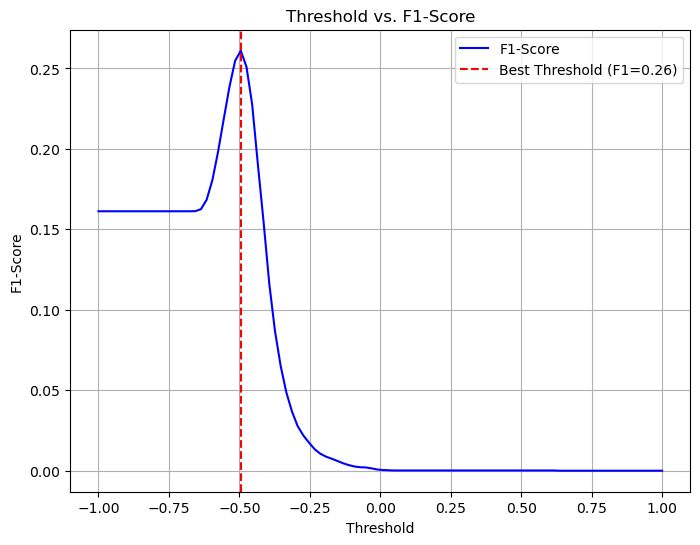

In [19]:
best_thresh = best_threshold(y, tx, w)

In [26]:
predictions = np.dot(tx, w)

pred_data = predictions.copy()
pred_data[pred_data > best_thresh] = 1
pred_data[pred_data <= best_thresh] = -1



correctly_classified_data = np.sum(pred_data == y)

tp = np.sum((pred_data == 1) & (y == 1))
fp = np.sum((pred_data == 1) & (y == -1))

tn = np.sum((pred_data == -1) & (y == -1))
fn = np.sum((pred_data == -1) & (y == 1))

accuracy_data = (tp + tn)/(tp + fp + tn + fn)

print(f"Accuracy: {accuracy_data*100}%")
print(f"Precision: {tp/(tp + fp)*100}%")
print(f"Recall : {tp/(tp + fn)*100}%")
print(f"F1-score : {tp/(tp + 0.5*(fn + fp))*100}%")

Accuracy: 79.86146383583909%
Precision: 19.240149771564013%
Recall : 40.557566980448954%
F1-score : 26.099112322639268%


Now we compute some metrics for our test data (40% of the total data)

In [16]:
pred_test = np.dot(tx_test, w)

pred_test[pred_test > best_thresh] = 1
pred_test[pred_test <= best_thresh] = -1

correctly_classified_test = np.sum(pred_test == y_test)

tp = np.sum((pred_test == 1) & (y_test == 1))
fp = np.sum((pred_test == 1) & (y_test == -1))

tn = np.sum((pred_test == -1) & (y_test == -1))
fn = np.sum((pred_test == -1) & (y_test == 1))

accuracy_test = (tp + tn)/(tp + fp + tn + fn)

print(f"Accuracy: {accuracy_test*100}%")
print(f"Precision: {tp/(tp + fp)*100}%")
print(f"Recall : {tp/(tp + fn)*100}%")
print(f"F1-score : {tp/(tp + 0.5*(fn + fp))*100}%")

Accuracy: 79.92334335495894%
Precision: 19.39599897409592%
Recall : 39.89449390042862%
F1-score : 26.101775352158253%


# Prediction on test data

In [ ]:
start_time = datetime.datetime.now()

tx_test = x_test
tx_test = preprocessing(x_test)
tx_test = gen_clean(tx_test, [], np.arange(321))

tx_test = tx_test[:, pca_indices]
tx_test = tx_test[:, :idx]
tx_test = np.c_[np.ones(tx_test.shape[0]), tx_test]

end_time = datetime.datetime.now()
print(f"Execution time {(end_time - start_time).total_seconds()} seconds")
print(f"The data has {tx_test.shape[0]} samples and {tx_test.shape[1]} features !")

In [ ]:
pred_te = np.dot(tx_test, w)

pred_te[pred_te > best_thresh] = 1
pred_te[pred_te < best_thresh] = -1

indices_one = np.where(pred_te == 1)

In [94]:
create_csv_submission(test_ids, pred_te, "../data/log_reg.csv")